In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [2]:
# Read the h-indices
df = pd.read_csv('../Data/train.csv', dtype={'author': np.int64, 'hindex': np.float32})

# Load the graph    
G = nx.read_edgelist('../Data/coauthorship.edgelist', delimiter=' ', nodetype=int)

In [3]:
# Computes some graph properties
core_num = nx.core_number(G)
eigenvector_cen = nx.eigenvector_centrality(G)

In [ ]:
betweenness_cen = nx.betweenness_centrality(G)
closeness_cen = nx.closeness_centrality(G)
katz_cen = nx.katz_centrality(G)
cfc_cen = nx.current_flow_closeness_centrality(G)
betweenness_cen = nx.betweenness_centrality(G)
cfb_cen = nx.current_flow_betweenness_centrality(G)
com_cen = nx.communicability_betweenness_centrality(G)
load_cen = nx.load_centrality(G)
subgraph_cen = nx.subgraph_centrality(G)
harmonic_cen = nx.harmonic_centrality(G)

Let's take a quick look at the data

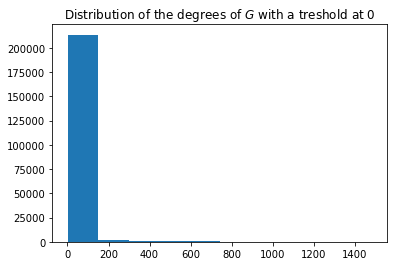

In [3]:
treshold = 0

# Degree distribution
l = []
for node in G:
    if G.degree(node) > treshold:
        l.append(G.degree(node))

plt.hist(l)
plt.title("Distribution of the degrees of $G$ with a treshold at {}".format(treshold))
print()

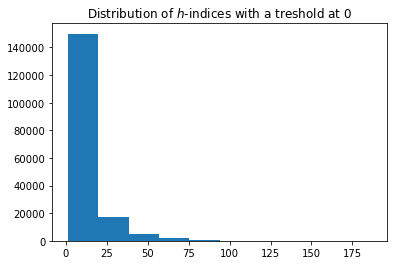

In [4]:
treshold = 0

# Distribution of h-indices
hindex = df['hindex']
plt.hist(hindex[hindex > treshold])
plt.title("Distribution of $h$-indices with a treshold at {}".format(treshold))
print()

# Learning

Here we attempt to predict the $h$-indices based only on properties of the graph

We split the dataframe into a dataframe for training and a dataframe for testing

In [202]:
# Fraction of samples in the training set
train_frac = 0.7
# Split the dataframe into train and test dataframes
df_train = df.sample(frac = train_frac)
df_test = df.drop(df_train.index)

### Baseline

We try to reproduce the score of the baseline using only the training dataset (because we do not have the answers for the testing dataset).

In [180]:
# Builds the feature vectors and target vector from the dataframe
# Here we reproduce the features of the baseline
def featvecs_baseline(df):
    n = df.shape[0]
    X = np.zeros((n,2))
    y = np.zeros(n)
    for i, x in zip(range(n), df.iterrows()):
        _, row = x
        X[i,0] = G.degree(row['author'])
        X[i,1] = core_num[row['author']]
        y[i] = row['hindex']
    return X,y

In [181]:
# Fitting a lasso model like in the baseline

X_train, y_train = featvecs_baseline(df_train)
print("Training features built")

X_test, y_test = featvecs_baseline(df_test)
print("Testing features built\n")

reg = Lasso(alpha = 0.1)
reg.fit(X_train, y_train)
print("Model fitted\n")

y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built

Model fitted

MSE: 128.4


### Experimental Area

Here is for experimenting with different kinds of graph-based features.

Let's try to add different powers of the degrees. In particular, we expect a dependance with the square root of the degree.

In [296]:
# Builds the feature vectors and target vector from the dataframe

def featvecs_experimental(df, powers):
    n = df.shape[0]
    X = np.zeros((n,len(powers)))
    y = np.zeros(n)
    for i, x in enumerate(df.iterrows()):
        _, row = x
        deg = G.degree(row['author'])
        cn = core_num[row['author']]
        for j, power in enumerate(powers):
            X[i,j] = deg ** power
            #X[i,j + len(powers)] = cn ** power
        y[i] = row['hindex']
    return X,y

In [300]:
# Fitting a lasso model like in the baseline

X_train, y_train = featvecs_nn(df_train)
print("Training features built")

X_test, y_test = featvecs_nn(df_test)
print("Testing features built")

reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built
Model fitted

MSE: 112.8


In [301]:
reg.coef_

array([16.62975098])

### Fitting the basic graph features with a neural network

We use different graph node features as input for a fully connected neural network.

In [299]:
# Builds the feature vectors and target vector from the dataframe

n_feat = 1

def featvecs_nn(df):
    
    n = df.shape[0]
    X = np.zeros((n, n_feat))
    y = np.zeros((n, 1))
    
    for i, x in enumerate(df.iterrows()):
        
        _, row = x
        node = row['author']
        
        # node degree
        X[i, 0] = G.degree(node) ** 0.2
        #X[i, 1] = core_num[node]
        #X[i, 2] = eigenvector_cen[node] * 1e5
        
        y[i] = row['hindex']
    
    return X,y

In [293]:
# Builds the feature vectors

X_train, y_train = featvecs_nn(df_train)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
print("Training features built")

# Normalize X_train
#X_train = nn.functional.normalize(X_train, dim = 0)

X_test, y_test = featvecs_nn(df_test)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
print("Testing features built")

# Normalize X_test
#X_test = nn.functional.normalize(X_test, dim = 0)

Training features built
Testing features built


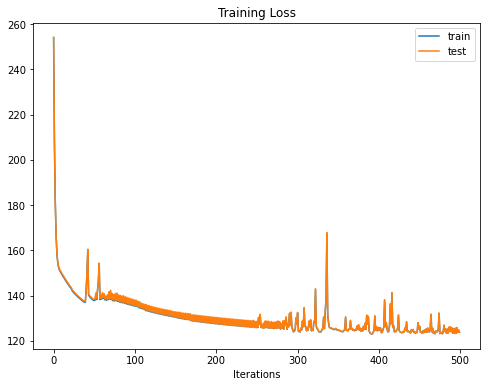

123.0


In [295]:
model = nn.Sequential(nn.Linear(n_feat, 20), nn.Tanh(), nn.Linear(20, 1))

loss_function = nn.MSELoss()
other_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

train_losses = []
test_losses = []

for epoch in range(500):
    
    # Update test loss
    output_test = model(X_test)
    test_losses.append(other_loss(output_test, y_test).item())
    
    # Optimization step
    output = model.forward(X_train)
    loss = loss_function(output, y_train)
    optimizer.zero_grad() #required since pytorch accumulates the gradients
    loss.backward() #backpropagation step
    optimizer.step() #update the parameters
    
    # Update train loss
    train_losses.append(loss.item())
    
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(train_losses, label = 'train')
ax.plot(test_losses, label = 'test')
ax.set_title("Training Loss")
ax.set_xlabel("Iterations")
plt.legend()
plt.show()

print("{:.4}".format(min(train_losses)))